# MLFlow in Practice

> In this notebook, we'll get started with MLFlow, learning how to create experiments, track our parameters and metrics, and eventually save and look at our model in the MLFlow user interface!

### Installing and importing packages

In [1]:
!pip install mlflow

In [2]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging

### Our first experiment!

The first thing we need to do is create an experiment in MLFlow to store information about our models. We will want to do this for each new model we want to track so that MLFlow knows to treat them separately

In [3]:
mlflow.set_experiment('mlflow-run-1')

2023/03/27 08:34:35 INFO mlflow.tracking.fluent: Experiment with name 'mlflow-run-1' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/zhangp1/class-demo/mlflow-demo/mlruns/807700333596781316', creation_time=1679924075351, experiment_id='807700333596781316', last_update_time=1679924075351, lifecycle_stage='active', name='mlflow-run-1', tags={}>

Now we're ready to start tracking parameters and metrics! We'll start off with some simple values to get acclamated to how it works.

We will also start the ML Flow UI with the command below. Open a new Terminal window and change directory to this directory. Then, paste the code. Click on the link generated to open the UI. This UI allows you to keep track of your experiments and results. 

In [4]:
# First, open a new terminal and change directory to where this repository is located. Then, run the following code:
#!mlflow ui
#Then open the generated link. (Likely looks like http://127.0.0.1:5000)

In [5]:
with mlflow.start_run():
    mlflow.log_param('parameter',3)
    mlflow.log_param('string-parameter','string')
    mlflow.log_metric('accuracy',1)

### Getting some actual numbers involved

Now let's generate some points. We're just going to create 100 points that are roughly in a line, keeping the line there to show what a model might produce if we asked it to learn these points.

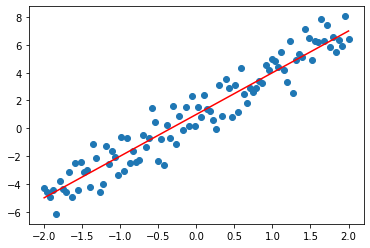

In [6]:
def f(x):
    return 3*x + 1
N = 100
x = np.linspace(-2,2,N)
y = f(x) + np.random.randn(N)

plt.plot(x,f(x),color = 'red')
plt.scatter(x,y);

These are our line parameters, slope and intercept. Currently, they are set to the line of best fit that we generated the data from, but we can change these because these are our parameters! Let's try that:

In [7]:
slope = 3
intercept = 1

The code below will show the new line based on the parameters above. Feel free to change the parameters and re-run this cell to see what the lines look like!

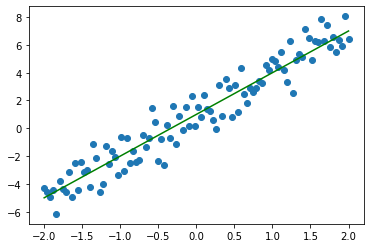

In [8]:
plt.plot(x,slope*x + intercept,color = 'green')
plt.scatter(x,y);

Now we need an evaluation metric. Here we will calculate the mean absolute error, which is just the average distance between each point and the green line. Re-run this cell whenever you change the input parameters and watch the error change in response

In [9]:
error = mean_absolute_error(y,slope*x + intercept)
print(error)

0.8567929241708631


In [10]:
mlflow.set_experiment('mlflow-run-2')

2023/03/27 08:34:35 INFO mlflow.tracking.fluent: Experiment with name 'mlflow-run-2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/zhangp1/class-demo/mlflow-demo/mlruns/744431533332270867', creation_time=1679924075983, experiment_id='744431533332270867', last_update_time=1679924075983, lifecycle_stage='active', name='mlflow-run-2', tags={}>

Now we can have MLFlow track these exact parameters and save the error too! Running this will log our run under the current experiment. Changing the parameters and running it again will add THAT run as well, and then the MLFlow UI will allow us to compare runs, sort them by error if we want, and see exactly what paramaters went into each one

Again, we'll want to first create another experiment. In the UI, this will create a new tab for these runs so that we can look at them separately

In [11]:
with mlflow.start_run():
    mlflow.log_param('slope',slope)
    mlflow.log_param('intercept',intercept)
    mlflow.log_metric('mean-sq-error',error)

To log another set of parameters as another run, simply change the values of the slope and intercept as below. Refreshing the ML Flow UI will show the new logged results.

In [12]:
slope = 4
intercept = 1

error = mean_absolute_error(y,slope*x + intercept)
print(error)

with mlflow.start_run():
    mlflow.log_param('slope',slope)
    mlflow.log_param('intercept',intercept)
    mlflow.log_metric('mean-sq-error',error)

1.2465394340560685


Now we have a good understanding of what MLFlow is actually doing, let's get to using it on a real model with some actual data

### Modeling on real data

Once again, it's important for us to create a new experiment to track this new model. We ALWAYS need to do this, or else our models will go to the same place!

In [13]:
mlflow.set_experiment('mlflow-run-3')

2023/03/27 08:34:36 INFO mlflow.tracking.fluent: Experiment with name 'mlflow-run-3' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/zhangp1/class-demo/mlflow-demo/mlruns/758929604358107951', creation_time=1679924076095, experiment_id='758929604358107951', last_update_time=1679924076095, lifecycle_stage='active', name='mlflow-run-3', tags={}>

The data we will be using here is Sci-Kit-Learn's wine-quality dataset, which contains some characteristics about various wines and then gives them a 'quality' score that we want to predict.

In [14]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=";")

Let's look at that data:

In [15]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Now let's get into some actual modeling. First, we need to split the data into training and test sets and make sure to separate the target column that we want to predict. That is done with the code below:

In [16]:
# Split the data into training and test sets
train, test = train_test_split(data)

# The target column is "quality"
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

The model we will use for this is an ElasticNet, which has two parameter we can adjust, alpha and l1_ratio

In [17]:
#Model Parameters
alpha = 0.8
l1_ratio = 0.5

Let's train the model and get some 

In [18]:
#Train Model
lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
lr.fit(train_x, train_y)

#Get Predictions
predicted_qualities = lr.predict(test_x)

It's as easy as that! Now let's see how we did. The metrics we will be looking at here are mean absolute error just like before, as well as root mean square error and r-squared

In [19]:
rmse = np.sqrt(mean_squared_error(test_y, predicted_qualities))
mae = mean_absolute_error(test_y, predicted_qualities)
r2 = r2_score(test_y, predicted_qualities)

print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

Elasticnet model (alpha=0.800000, l1_ratio=0.500000):
  RMSE: 0.772756118129038
  MAE: 0.6380160877763658
  R2: 0.04360037140202644


Now let's do all of that as an mlflow run and watch it appear in the UI!
We'll also add one final step for mlflow to log the model itself for us to be able to get later as well.

In [20]:
with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(test_y, predicted_qualities))
    mae = mean_absolute_error(test_y, predicted_qualities)
    r2 = r2_score(test_y, predicted_qualities)

    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    mlflow.sklearn.log_model(lr, "model")

Elasticnet model (alpha=0.800000, l1_ratio=0.500000):
  RMSE: 0.772756118129038
  MAE: 0.6380160877763658
  R2: 0.04360037140202644


/Users/zhangp1/opt/anaconda3/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Now let's look at how we could get that model back and predict on our data!

In [23]:
logged_model = 'mlruns/<EXP_ID>/<MODEL_ID>/artifacts/model'
# logged_model = 'mlruns/777930285435130117/40252f529a95424da5f667aeae4721df/artifacts/model' ##EXAMPLE

loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
predictions = pd.DataFrame(loaded_model.predict(test_x))

And here we are, now we have the predictions from that model, and this code could be run in any notebook in this repo, allowing the quick and easy versioning of models accross a project!

In [24]:
predictions.head(10)

,0
0,5.453236
1,5.297683
2,5.717179
3,5.673450
4,5.644071
5,5.504827
6,5.548161
7,5.736342
8,5.268399
9,5.707942


We can also run multiple experiments in one go, by putting our code in a for loop. If you were to use cross validation, you can also implement this code within the code for cross validation and log your results. 

In [ ]:
#Model Parameters
alphas = [0.1,0.2,0.3,0.4]
l1_ratios = [0.1,0.2,0.3,0.4]

for alpha_val in alphas:
    for l1_val in l1_ratios:
        with mlflow.start_run():
            lr = ElasticNet(alpha=alpha_val, l1_ratio=l1_val, random_state=42)
            lr.fit(train_x, train_y)

            predicted_qualities = lr.predict(test_x)

            # Evaluation Metrics
            rmse = np.sqrt(mean_squared_error(test_y, predicted_qualities))
            mae = mean_absolute_error(test_y, predicted_qualities)
            r2 = r2_score(test_y, predicted_qualities)

            print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha_val, l1_val))
            print("  RMSE: %s" % rmse)
            print("  MAE: %s" % mae)
            print("  R2: %s" % r2)

            mlflow.log_param("alpha", alpha_val)
            mlflow.log_param("l1_ratio", l1_val)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae", mae)

            mlflow.sklearn.log_model(lr, "model")

Elasticnet model (alpha=0.100000, l1_ratio=0.100000):
  RMSE: 0.6518918312122391
  MAE: 0.5199992368837985
  R2: 0.31937864328128673
Elasticnet model (alpha=0.100000, l1_ratio=0.200000):
  RMSE: 0.6593780870070142
  MAE: 0.5262601028502496
  R2: 0.3036565179178704
Elasticnet model (alpha=0.100000, l1_ratio=0.300000):
  RMSE: 0.6666591379380109
  MAE: 0.5320582381706132
  R2: 0.28819314322922607
Elasticnet model (alpha=0.100000, l1_ratio=0.400000):
  RMSE: 0.6717754521606529
  MAE: 0.5360696068437336
  R2: 0.2772256126115721


Now, when you reload the ML Flow UI, you'll see all these runs logged with all the relevant values recorded. 